# **AyaFestPe**

---


Your multi-lingual and multi-cultural festival exploration guide!

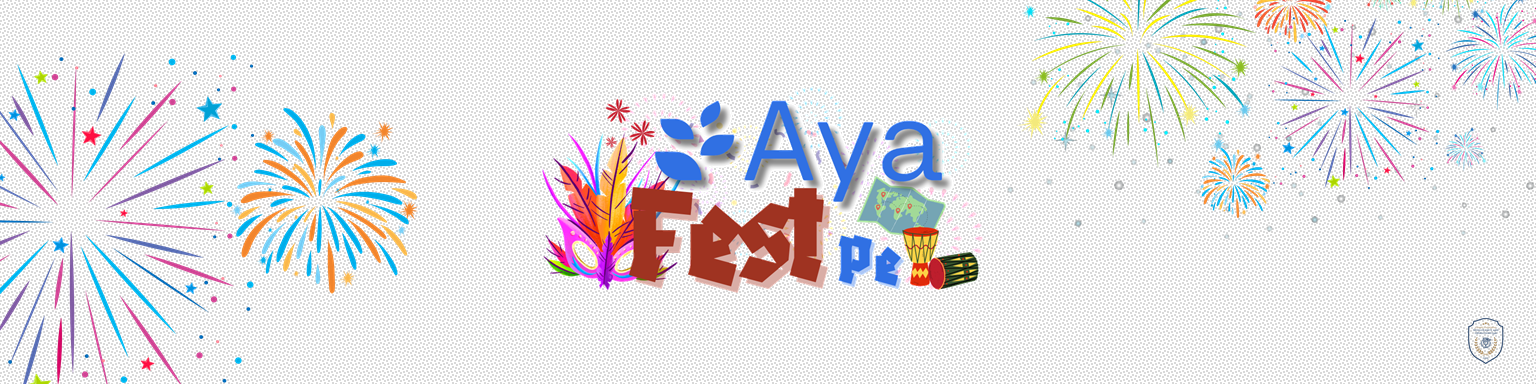

<div style="text-align: center;">
    <i><b>Azmine Toushik Wasi, Wahid Faisal</b></i>

</div>

---

    
<div style="text-align: left; font-size: small;">
    Cohere for AI Community</br>
    Computational Intelligence and Operations Laboratory </br>
    <i>*Both authors contributed equally</i>
</div>


Watching videos and photos of festivals on social media, news channels, and television often makes us wonder if we could join or visit one ourselves. Festivals are a beautiful combination of culture, music, dance, art, and food. They bring people together, showcasing unique traditions and celebrations that vary from place to place. The joy of experiencing a festival firsthand is a strong desire many of us share.

However, cultural and language differences can pose challenges when preparing for these festivals. Different places have their own customs, traditions, and languages, which can make it hard to fully understand and participate. Additionally, food preparation can be tricky, as every festival often features special dishes that may be unfamiliar or hard to make without local knowledge.

To ease your way into the festival experience, we designed this notebook where you can talk and learn about festivals in your own language, with responses that are more culturally and linguistically aligned. We use new mystery model by Cohere with multilingual retrieval-augmented generation (RAG) to help you explore and enjoy festivals from around the world.


---

*AyaFestPe* means "I'm coming to the festival" in Hindi. We chose this name because it rhymes nicely with "aya," creating a catchy and memorable title for our festival initiative.  This notebook showcases extra-ordinary multi-lingual and multi-cultural capabilities of `Aya-Expanse`.

**Process Overview:** The festival exploration pipeline begins by collecting festival data from Hugging Face, which provides rich information about various celebrations. Next, we use the Mystery Model to translate this data into different languages, making it accessible to a wider audience. Afterward, we collect user queries to understand what information they are looking for. We then use retrieval-augmented generation (RAG) by embedding all the data and user queries. This allows us to rerank the results and gather relevant context for the user’s query. Finally, we combine this context with the user query to generate meaningful and informative output tailored to their needs.

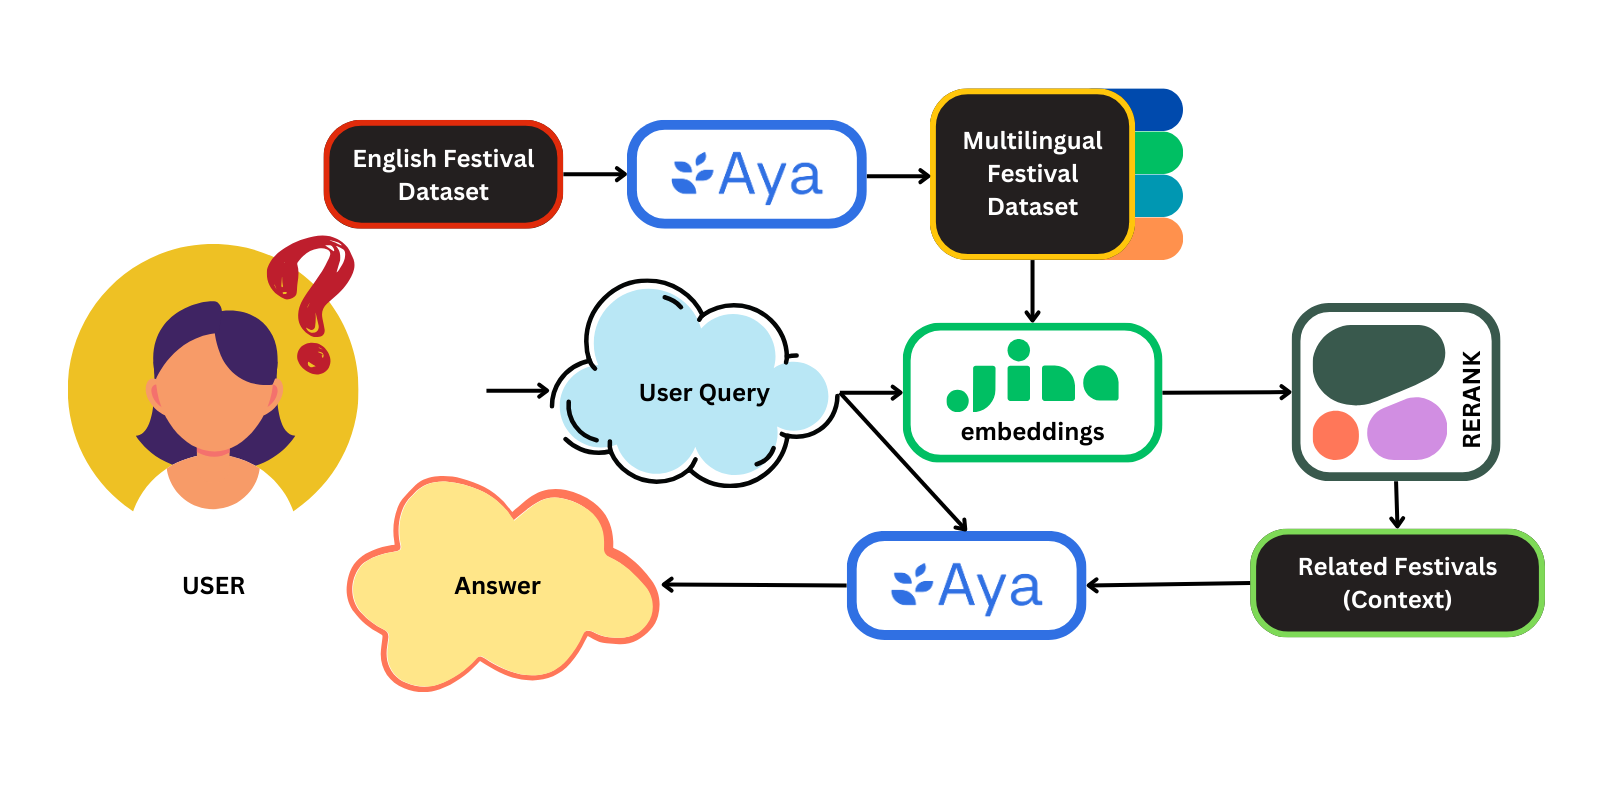

## 💻 1: Workplace Setup

Installing some specific versions to avoid problem with some other packages.

In [1]:
## imports
!pip install -q 'numpy<2' datasets cohere torch transformers einops faiss-cpu
!pip install -q -U numpy==1.23.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.1 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires urllib3<2.0.0, but you have urllib3 2.2.3 which is incompatible.
rapids-dask-dependency 24.8.0a0 requires dask==2024.7.1, but you have dask 2024.9.1 which is incompatible.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires p

In [2]:
!pip install --upgrade accelerate
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 13.2 MB/s eta 0:00:00


**Importing necessary packages and modules**: At first, we will import some necessary modules that will help us in building our notebook. We use standard libraries like `os`, `json`, and `re` for file handling and string manipulation. Libraries such as `numpy` and `torch` provide support for numerical computations and machine learning tasks. In a Google Colab environment, we utilize `IPython.display` for rendering HTML and audio, while `transformers` and `datasets` from Hugging Face enable us to work with state-of-the-art NLP models and datasets. Finally, `cohere` gives us access to advanced natural language processing capabilities.

In [3]:
## default python imports
import os
import json
import re
import ast
import base64
import io
from dataclasses import dataclass, field
from typing import List, Tuple
import random

## pythonic imports and torch
import numpy as np
import tqdm
import torch

## HF imports for the embedding model
from transformers import BitsAndBytesConfig
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
import datasets
from datasets import load_dataset, DatasetDict, Dataset
from huggingface_hub import login

## cohere
import cohere

## colab secrets
from kaggle_secrets import UserSecretsClient

***Note:*** Defining our API keys for **Cohere** and **Hugging Face** along with fixed variables, such as the model name and supported languages. We used `kaggle secrets` to save our keys.

In [4]:
COHERE_API_KEY = UserSecretsClient().get_secret('COHERE_API_KEY_p')
HF_API_KEY = UserSecretsClient().get_secret('HF_KEY')
COHERE_MODEL = "/kaggle/input/aya-expanse/transformers/8b/1"
EMBEDDING_MODEL = 'jinaai/jina-embeddings-v3' # You can use other embedding models too.
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
GLOBAL_FESTIVALS_DATASET = 'ciol-research/global-festivals-wiki'
GLOBAL_FESTIVALS_DATASET_T = 'azminetoushikwasi/global-festivals-translated' # Change as necessary.
LANGUAGES = ['english', 'german', 'french', 'spanish', 'indian', 'japanese', 'korean', 'turkish', 'italian']

## 🧭 2: Loading Necessary Models and APIs

Configure **Cohere** by providing your Cohere API Key and creating an instance of the Cohere API. Next, connect to our embedding model (`EMBEDDING_MODEL = 'jinaai/jina-embeddings-v3'`) using `AutoModel` from the **Hugging Face** `transformers` library. We'll also use Hugging Face for dataset management, so let’s log in there too.

In [5]:
# Initialize the cohere API
co = cohere.ClientV2(COHERE_API_KEY)

In [6]:
# Initialize the Aya Expanse model
tokenizer = AutoTokenizer.from_pretrained(COHERE_MODEL)
model = AutoModelForCausalLM.from_pretrained(COHERE_MODEL, quantization_config=quantization_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
# Initialize the Jina embedding model
embedding_model = AutoModel.from_pretrained(EMBEDDING_MODEL, trust_remote_code=True, use_flash_attn=False).to(DEVICE)

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

configuration_xlm_roberta.py:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_lora.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

embedding.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


rotary.py:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


stochastic_depth.py:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mlp.py:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mha.py:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_xlm_roberta.py:   0%|          | 0.00/50.0k [00:00<?, ?B/s]

block.py:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- block.py
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_lora.py
- embedding.py
- rotary.py
- stochastic_depth.py
- mlp.py
- mha.py
- modeling_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [8]:
# Login to HF
login(token=HF_API_KEY)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## 🎊 3: Generating Multi-lingual Festival Data

In this section, we will focus on generating multilingual festival data. By leveraging our configured models and APIs, we will create rich and diverse information about festivals from around the world, ensuring accessibility in multiple languages.

***Note:***  At first, we will collect the festival data from Hugging Face if started from scratch. As mentioned previously, this data is avaiable here in `GLOBAL_FESTIVALS_DATASET = 'ciol-research/global-festivals-wiki'`. It has 20K festival data collected from wikipedia in English.

In [9]:
# Function to check if 'title', 'country', and 'description' are not None
def filter_invalid_rows(example):
    return example['title'] is not None and example['country'] is not None and example['description'] is not None

***Note:*** `translate_festival_data` function selects a specified number of random festival samples from a dataset and translates their descriptions into multiple languages. It takes three parameters: the dataset of festivals, the number of samples to process, and the maximum character limit for each description. By truncating lengthy descriptions and generating translation prompts, the function uses the configured Cohere API to obtain translations. Finally, it saves the translated data in a JSONL file for further use, ensuring accessibility of festival information across different languages.

In [10]:
def translate_festival_data(fest_data, model, tokenizer, num_samples=200, max_chars=300):
    '''
    Selects random festival samples and translates their descriptions into multiple languages using a local language model.

    Args:
      fest_data: Hugging Face dataset containing festival data in English.
      model: Pretrained Hugging Face model for translations.
      tokenizer: Tokenizer for the Hugging Face model.
      num_samples (int): Number of random festivals to process.
      max_chars (int): Maximum number of characters for the description.

    Returns:
      Translated dataset in multiple languages and prints selected festivals.
    '''

    # Step 1: Select random festivals
    festival_samples = fest_data.shuffle(seed=42).select(range(num_samples))

    # Step 2: Print the selected festival names and countries
    selected_festivals = [(fest['title'], fest['country']) for fest in festival_samples]
    print(", ".join([f"{title} ({country})" for title, country in selected_festivals]))

    translated_entries = []

    for sample in tqdm.tqdm(festival_samples, desc="Translating festival data"):
        title = sample['title']
        country = sample['country']
        description_en = sample['description']

        # Step 3: Truncate the description to the first `max_chars` characters
        try:
            description_en = description_en[:max_chars]
        except Exception as e:
            print(f"Error processing {title} ({country}): {e}")
            continue

        # Step 4: Initialize dictionary to hold the translations for each language
        translations = {'title': title, 'country': country, 'description': {'english': description_en}}

        for lang in LANGUAGES[1:]:  # Skip 'english' as it's already present
            # Generate the translation using the local model
            prompt = f"Translate the following festival description into {lang}: {description_en}."
            input_ids = tokenizer.apply_chat_template(
                [{"role": "user", "content": prompt}], tokenize=True, add_generation_prompt=True, return_tensors="pt"
            )
            input_ids = input_ids.to(DEVICE)

            # Generate the translation with the model
            try:
                gen_tokens = model.generate(input_ids, max_new_tokens=100, do_sample=True, temperature=0.3)
                translated_description = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)

                # Add the translated description to the dictionary
                translations['description'][lang] = translated_description
            except Exception as e:
                print(f"Error translating to {lang} for {title} ({country}): {e}")
                translations['description'][lang] = None

        # Append the translated festival data to the list
        translated_entries.append(translations)

    # Step 5: Write the translated festival data to a JSONL file
    with open('translated_festivals.jsonl', 'w', encoding='utf-8') as f:
        for entry in translated_entries:
            f.write(json.dumps(entry, ensure_ascii=False) + '\n')

    print('Translated data dumped to ./translated_festivals.jsonl')

    return translated_entries


***Note*** `create_translated_festival_dataset` function loads the original festival dataset and translates it, creating a new dataset on Hugging Face. It allows users to choose between using a default uploaded dataset or generating a new one from the translated entries.

In [11]:
# The descriptions are nested, which could be problematic in later stages like retrieval-augmented generation (RAG). Let's flatten them.

def flatten_dataset(fest_data_translated):
    
    # Assuming the festival dataset is loaded as 'fest_data_translated'
    festivals_dataset = fest_data_translated['train']  # Use the appropriate split

    # Step 1: Create a list to hold the flattened data
    flattened_festivals = []

    # Step 2: Iterate through the original dataset and flatten the descriptions
    for festival in festivals_dataset:
        title = festival['title']
        country = festival['country']

        # For each language description, create a new entry
        for lang, description in festival['description'].items():
            flattened_festivals.append({
                'title': title,
                'country': country,
                'language': lang,
                'description': description
            })

    # Step 3: Create a new Hugging Face dataset from the flattened data
    flattened_festivals_dataset = Dataset.from_list(flattened_festivals)
    
    return flattened_festivals_dataset

In [12]:
def create_translated_festival_dataset(use_default=True):
    '''
    Loads the original festival dataset, translates it, and creates a new dataset on Hugging Face.

    Args:
      use_default (bool): Whether to use the default uploaded dataset or create a new one.

    Returns:
      Hugging Face dataset with translations.
    '''

    if use_default:
        dataset = load_dataset(GLOBAL_FESTIVALS_DATASET_T)['train']
        
    else:
        # Loading festival data
        festivals_dataset = load_dataset(GLOBAL_FESTIVALS_DATASET)

        # Apply the filter function to the dataset
        filtered_dataset = festivals_dataset['train'].filter(filter_invalid_rows)
        
        # Print the number of rows before and after filtering
        print(f"Original dataset size: {len(festivals_dataset['train'])}")
        print(f"Filtered dataset size: {len(filtered_dataset)}")
        
        # Translate
        translated_entries = translate_festival_data(filtered_dataset)  # Call translation function
        dataset = load_dataset('json', data_files='translated_festivals.jsonl')
        
        dataset = flatten_dataset(dataset)
        
        # Push to Hugging Face Hub
        dataset.push_to_hub(GLOBAL_FESTIVALS_DATASET_T)

    return dataset

Creating the multi-lingual dataset.

In [13]:
# Using the functions to create a dataset
final_festivals_dataset = create_translated_festival_dataset(use_default=True)

README.md:   0%|          | 0.00/654 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/465k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1800 [00:00<?, ? examples/s]

Let's take a look at the dataset to ensure everything is in order.

In [14]:
# Examining the dataset
final_festivals_dataset[0:9]

{'title': ['Epica Awards',
  'Epica Awards',
  'Epica Awards',
  'Epica Awards',
  'Epica Awards',
  'Epica Awards',
  'Epica Awards',
  'Epica Awards',
  'Epica Awards'],
 'country': ['France',
  'France',
  'France',
  'France',
  'France',
  'France',
  'France',
  'France',
  'France'],
 'language': ['english',
  'german',
  'french',
  'spanish',
  'indian',
  'japanese',
  'korean',
  'turkish',
  'italian'],
 'description': ['epica award annual series communication award created based paris france originally focused europe middle east africa region exclusively award became global agency total submitted work epica award representing country epicas aim reward outstanding creativity help communication agency film production',
  'Epica Award: Jährliche Serie des Kommunikationspreises, ursprünglich aus Paris, Frankreich, geschaffen und auf die Region Europa, Naher Osten und Afrika fokussiert, wurde zu einem globalen Preis. Insgesamt eingereichte Arbeiten repräsentieren Länder und Epi

## 🥳 4: Using RAG for Context-rich Response

Users can enter their queries in the input box.

In [15]:
query = "Parlami del codice di abbigliamento del festival \"Toran La\" in Nepal?" #@param {type:"string"}

***Note:*** We use `Jina embeddings-v3` to construct the `retrieval-augmented generation` (RAG) `index` for our festival dataset. This process involves creating a list of festival descriptions to encode and then generating numerical representations by applying the Jina embeddings model. Once the embeddings are created, we add them to our dataset object to associate them with their respective festival entries. Finally, we utilize the built-in functionality from Hugging Face to create a FAISS index, which enables efficient retrieval of relevant festival data based on user queries.

In [16]:
# Creating a list of festival descriptions for different languages
# Extracting the descriptions for each language
festivals_list = []
for festival in final_festivals_dataset:
    # Collect the description for the specific language
    festivals_list.append(festival['description'])  # Directly access the description

# Encoding the list of festival descriptions using the embedding model
if "embeddings" not in final_festivals_dataset.features:
    embeddings = embedding_model.encode(festivals_list, task="retrieval.passage")

    # Adding the embeddings list to the dataset object
    final_festivals_dataset = final_festivals_dataset.add_column("embeddings", embeddings.tolist())

    # Creating FAISS index using HF dataset's in-built method
    final_festivals_dataset.add_faiss_index("embeddings")
else:
    print(f"Already Embedded!")

# Collecting nearest festivals to user query
def get_nearest_festivals(query, embedding_model, dataset, k: int = 10):
    # Encode the user query using the embedding model for retrieval
    query_embedding = embedding_model.encode(query, task="retrieval.query")

    # Retrieve the top k nearest festivals based on the encoded query
    scores, retrieved_festivals = dataset.get_nearest_examples('embeddings', query_embedding, k=k)

    # Extract the titles of the retrieved festivals for the result
    result = [r for r in retrieved_festivals['title']]

    return result

# Call the function to get the nearest festivals based on the user query
retrieved_festivals = get_nearest_festivals(query, embedding_model, final_festivals_dataset, k=5)

Encoding:   0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Encoding:   0%|          | 0/1 [00:00<?, ?it/s]

***Note:*** Re-ranking helps us find the best festivals based on the user's query. We use the Cohere client with a reranking model to improve the results. This process makes sure the festivals we show are relevant to what the user wants. It provides a better selection of festival descriptions that match the user's interests.

In [17]:
def rerank_festivals(retrieved_festivals: List[str], query: str, cohere_client, top_n: int = 1):
    # Use the Cohere client to rerank the retrieved festivals based on the user query
    response = cohere_client.rerank(
        model="rerank-multilingual-v3.0",  # Specify the model to use for reranking
        query=query,  # The user's query to evaluate against the retrieved festivals
        documents=retrieved_festivals,  # The list of festivals to rerank
        top_n=top_n,  # Number of top results to return
        return_documents=True  # Indicate that we want the original documents in the response
    )

    # Extract the text of the top-ranked documents from the response
    result = [res.document.text for res in response.results]

    return result  # Return the reranked list of festival descriptions

In [18]:
# Checking our our user query
context = rerank_festivals(retrieved_festivals, query, co, top_n=1)
print(context[0])

Toran La


Let's use `Aya-Expanse` to generate answers to user queries. This function takes context and a query to produce relevant responses.

In [19]:
# Define a prompt template for generating answers based on a given context and query
prompt_template = (
    "Given the context and a query, generate the answer to the query from the given context information. "
    "Base your response with context to create more helpful and culturally aligned output. Be creative in writing form.\n\n"
    "Context: {context}\n\n"
    "Query: {query}\n\n"
    "Translate the answer to the query language.\n\n"
    "Answer:"
)

# Format the prompt with the first context entry and the user's query
prompt = prompt_template.format(context=context[0], query=query)

In [20]:
def generate_answer(prompt, model, tokenizer):
    '''
    Generates an answer based on the formatted prompt using a local language model.

    Args:
      prompt: The prompt text to be processed by the language model.
      model: The pre-trained Hugging Face model used to generate the answer.
      tokenizer: Tokenizer corresponding to the pre-trained model.

    Returns:
      answer: The generated answer based on the prompt.
    '''
    
    # Step 1: Tokenize the input prompt
    input_ids = tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}], tokenize=True, add_generation_prompt=True, return_tensors="pt"
    )
    input_ids = input_ids.to(DEVICE)

    # Step 2: Use the model to generate a response based on the prompt
    gen_tokens = model.generate(
        input_ids,  # Pass the tokenized input
        max_new_tokens=500,      # Limit the number of tokens in the generated response
        do_sample=True,          # Enable sampling to introduce randomness in the output
        temperature=0.3          # Control the randomness of predictions; lower values make output more deterministic
    )

    # Step 3: Decode the generated tokens to get the text
    answer = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)

    return answer  # Return the generated answer

In [21]:
# Call the function to generate an answer using the prompt and the Cohere client
answer = generate_answer(prompt, model, tokenizer)
print(answer)  # Print the generated answer

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


<|START_OF_TURN_TOKEN|><|USER_TOKEN|>Given the context and a query, generate the answer to the query from the given context information. Base your response with context to create more helpful and culturally aligned output. Be creative in writing form.

Context: Toran La

Query: Parlami del codice di abbigliamento del festival "Toran La" in Nepal?

Translate the answer to the query language.

Answer:<|START_OF_TURN_TOKEN|><|CHATBOT_TOKEN|>Il festival "Toran La" in Nepal è un'occasione ricca di tradizioni e colori, e il codice di abbigliamento riflette questa importanza culturale. Durante il festival, i partecipanti indossano abiti tradizionali che variano a seconda della regione e dell'etnia.

Per gli uomini, l'abbigliamento tipico include il "Kachhara" o "Dhoti", un lungo pezzo di stoffa avvolto intorno alla vita e alle caviglie, spesso accompagnato da una camicia chiamata "Kurta". Il capo è completato da un cappello tradizionale chiamato "Topi" o "Daura".

Le donne, invece, indossano 

## 💃 5. Example using the pipeline

---
### Output Example 1
---


#### **Query**: (Hindi/Indian)
मैं दिसंबर 2024 में स्विट्ज़रलैंड में चैलैंडमर्ज फ़स्टिवल की यात्रा करना चाहता हूं। क्या यह अच्छा समय है?
#### **Query (Translated to English)**:
I want to visit Chalandamarz festival in Switzerland in December 2024. Is it a good time?

#### **Response**:

यदि आप दिसंबर 2024 में स्विट्ज़रलैंड के चैलैंडमर्ज़ फ़ेस्टिवल का अनुभव करने की योजना बना रहे हैं, तो यह निश्चित रूप से एक शानदार समय होगा!

स्विट्ज़रलैंड का यह जादुई त्यौहार आमतौर पर सर्दियों के महीनों में आयोजित किया जाता है, और दिसंबर एक आदर्श समय है क्योंकि यह त्यौहार का मुख्य आकर्षण है। इस समय के दौरान, स्विस संस्कृति और परंपराओं का जश्न मनाया जाता है, जिसमें पारंपरिक परिधान, संगीत, नृत्य और स्थानीय व्यंजनों का प्रदर्शन शामिल है। चैलैंडमर्ज़ के दौरान, स्विट्ज़रलैंड के विभिन्न क्षेत्रों से लोग एक साथ आते हैं, जो एक जीवंत और रंगीन उत्सव का माहौल पैदा करते हैं।

दिसंबर में, आप बर्फ से ढके परिदृश्यों का आनंद ले सकते हैं, जो इस त्यौहार को और भी आकर्षक बनाता है। स्विट्ज़रलैंड के कई शहरों और गांवों में सड़कों को सजाया जाता है, और पारंपरिक लाइट्स और सजावटों से एक जादुई वातावरण पैदा होता है। यह समय स्थानीय व्यंजनों का आनंद लेने और स्विस संस्कृति का प्रमाणिक अनुभव करने के लिए भी आदर्श है।

इसलिए, यदि आप सर्दियों के जादू का अनुभव करने, स्थानीय परंपराओं का सम्मान करने और स्विट्ज़रलैंड की सुंदरता का पता लगाने के लिए तैयार हैं, तो दिसंबर 2024 में चैलैंडमर्ज़ फ़ेस्टिवल के लिए अपनी यात्रा की योजना बनाना एक उत्कृष्ट विकल्प होगा!


#### **Response (Translated to English)**:

If you are planning to experience the Chaillandmerz Festival in Switzerland in December 2024, it will definitely be a wonderful time!

This magical festival in Switzerland is typically held during the winter months, and December is an ideal time as it is the main highlight of the festival. During this period, Swiss culture and traditions are celebrated, featuring traditional attire, music, dance, and local cuisine. People from various regions of Switzerland come together during Chaillandmerz, creating a lively and colorful festival atmosphere.

In December, you can enjoy the snow-covered landscapes, making this festival even more enchanting. The streets of many cities and villages in Switzerland are decorated, creating a magical ambiance with traditional lights and decorations. This time is also perfect for enjoying local dishes and having an authentic experience of Swiss culture.

So, if you are ready to experience the magic of winter, honor local traditions, and explore the beauty of Switzerland, planning your trip for the Chaillandmerz Festival in December 2024 will be an excellent choice!


#### **Insights/Discussion**:
This example output demonstrates how our pipeline gives accurate information about the Chalandamarz Festival in Switzerland. It answers the user's question in Hindi, showing our ability to provide multilingual support. The response includes local cultural details like traditional clothing and food, which helps the user understand the festival better.


---
### Output Example 2
---


#### **Query**: (Italian)
Parlami del codice di abbigliamento del festival "Toran La" in Nepal?
#### **Query (Translated to English)**:
Tell me about dress code of 'Toran La' festival in Nepal?
#### **Response**:
Il festival "Toran La" in Nepal è un'occasione speciale che celebra le tradizioni e la cultura locale, e il codice di abbigliamento riflette la ricchezza e la diversità di queste usanze. Durante il festival, gli abitanti del luogo e i visitatori sono incoraggiati a indossare abiti tradizionali che variano a seconda delle regioni e delle tribù.

Per gli uomini, l'abbigliamento tipico include il "Daura" (una tunica lunga) abbinata a pantaloni larghi chiamati "Kusum". Spesso, gli uomini indossano anche un cappello tradizionale chiamato "Topi" e calzature fatte di pelle. I colori vivaci e i ricami intricati sono elementi comuni in questi abiti da uomo.

Le donne, invece, sfoggiano abiti eleganti e colorati, come il "Choli" (una camicetta aderente) e il "Lehenga" (una gonna lunga e ampia) con un corpetto decorato. Il "Rasu" o velo è un accessorio importante per le donne, che lo indossano con grazia e dignità. I gioielli, in particolare collane, orecchini e bracciali, aggiungono un tocco di splendore al loro look.

Il codice di abbigliamento di "Toran La" mira a preservare le antiche tradizioni tessili e artigianali del Nepal. I colori e i motivi utilizzati nei vestiti spesso derivano dalla natura circostante, riflettendo la bellezza delle montagne, delle valli e delle foreste del paese.

Partecipare al festival con abiti tradizionali non è solo una questione di stile, ma anche un modo per onorare le radici culturali e rafforzare il senso di comunità. L'atmosfera festosa e la varietà di costumi creano un'esperienza visivamente affascinante per tutti i presenti.
#### **Response (Translated to English)**:
The "Toran La" festival in Nepal is a special occasion that celebrates local traditions and culture, and the dress code reflects the richness and diversity of these customs. During the festival, locals and visitors are encouraged to wear traditional clothing that varies by region and tribe.

For men, typical attire includes the "Daura" (a long tunic) paired with wide trousers called "Kusum." Often, men also wear a traditional hat known as "Topi" and leather footwear. Bright colors and intricate embroidery are common elements in these men's garments.

Women, on the other hand, showcase elegant and colorful outfits, such as the "Choli" (a fitted blouse) and the "Lehenga" (a long, wide skirt) with a decorated bodice. The "Rasu" or veil is an important accessory for women, worn with grace and dignity. Jewelry, particularly necklaces, earrings, and bracelets, adds a touch of splendor to their look.

The dress code for "Toran La" aims to preserve the ancient textile and artisan traditions of Nepal. The colors and patterns used in the clothing often derive from the surrounding nature, reflecting the beauty of the mountains, valleys, and forests of the country.

Participating in the festival with traditional attire is not just a matter of style but also a way to honor cultural roots and strengthen the sense of community. The festive atmosphere and variety of costumes create a visually captivating experience for everyone present.

#### **Insights/Discussion**:
This example output highlights how our pipeline effectively provides detailed information about the dress code for the "Toran La" festival in Nepal. It answers the user's question in Italian, showcasing our multilingual capabilities. The response includes rich cultural details about traditional attire for both men and women, emphasizing the importance of clothing in preserving local customs. This not only enhances the user's understanding of the festival but also reflects the system's ability to blend language diversity with cultural depth, making it a valuable resource for festival information.

---

Thanks for your time! We hope you enjoyed our work.

### Cite as:

```
@techreport{wasi-wahid-ayafestpe,
  author      = "Azmine Toushik Wasi and Wahid Faisal",
  title       = "AyaFestPe : A Multi-lingual and Multi-cultural Festival Exploration Guide",
  institution = "Cohere for AI Community and Computational Intelligence and Operations Laboratory",
  year        = "2024",
  url         = "https://github.com/azminewasi/AyaFestPe"
}
```

#### Acknowledgements
1. Thanks a lot of *Bhavnick Minhas* and *Sree Harsha Nelaturu* for sharing their work *AyaMCooking*. The RAG part is highly inspired from their work, and we learned a lot from that.
2. Thanks to *Cohere* and *Cohere for AI* for providing API credits and their support for open source community works.
3. Can't thank *HF* enough for their platform, API and Python libraries.
4. Thanks to Kaggle for this amazing platform.